# QSVMs

In [1]:
# Qiskit imports
from qiskit.circuit.library import UnitaryOverlap
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms.classifiers import QSVC
from qiskit_aer import AerSimulator, Aer
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
with open('../../api_key.txt', 'r') as file:
    token = file.read()

service = QiskitRuntimeService(channel="ibm_quantum",token=token)

In [2]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Helper functions

In [3]:
def fidelity_circuit(ansatz_1,ansatz_2,display=False):
    """Create a fidelity circuit to estimate the similarity of two states."""
    fc = ansatz_1.copy()
    fc.append(ansatz_2.inverse().decompose(), range(fc.num_qubits))
    fc.measure_all()
    if display == True:
        print(fc.decompose())
    return fc

def plot_matrix(A, title):
    """Plots a given matrix A."""
    plt.title(title)
    ax = plt.imshow(A, cmap='viridis')
    plt.colorbar(ax)
    plt.tight_layout()
    plt.show()

In [4]:
# Instantiate backends
aer_backend = AerSimulator() # a local quantum simulator
# qasm_backend = service.get_backend('ibmq_qasm_simulator') # a remote quantum simulator
# ibmq_backend = service.get_backend('ibm_brisbane') # a real ibm quantum computer

## Load data

We creat a synthetic dataset.

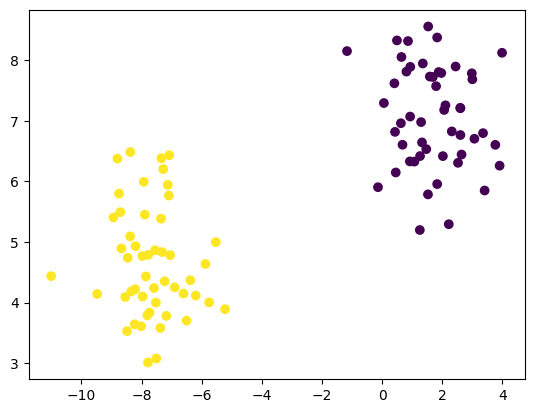

In [5]:
feature_dim = 2
X,y = make_blobs(n_samples=100, n_features=feature_dim, centers=2)
plt.scatter(X[:,0],X[:,1],c=y)

Create a **training** and **test** set for featurevector and labels.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

## Define Ansatz - Feature Map

In [9]:
# Define a ZZ feature map circuit (ansatz_zz) as ansatz. Display the circuit and its decomposition.

# Your code goes here
ansatz_zz = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear")

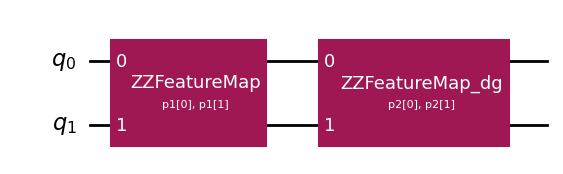

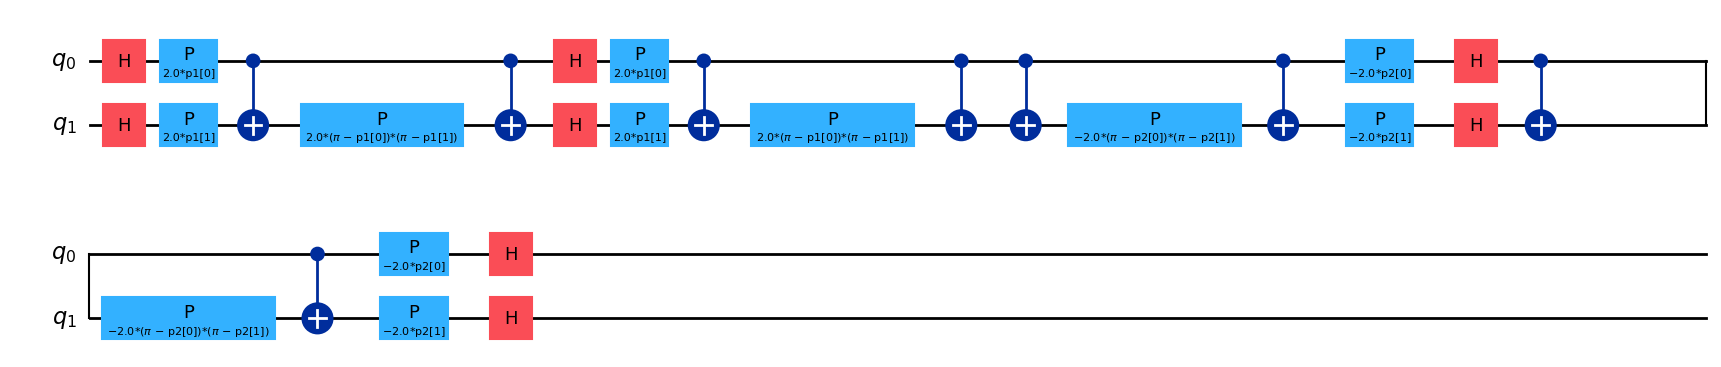

In [12]:
fc = UnitaryOverlap(ansatz_zz,ansatz_zz)
display(fc.draw("mpl"))
fc.decompose(reps=1).draw("mpl")

**Note:**

This fidelity circuit corresponds to the Kernel definition $K_{ij} = \langle 0| U^{\dagger}_{\phi(x^i)} U_{\phi(x^j)} |0 \rangle$. 


## Instantiate the QSVC object

In [14]:
# Instantiate the QSVC object

# Your code goes here
sampler = AerSampler()
fidelity = ComputeUncompute(sampler=sampler)
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=ansatz)
qsvc = QSVC(quantum_kernel=kernel)


## Train

In [15]:
# Train the QSVC classifier

# Your code goes here
qsvc.fit(X_train,y_train)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.fidelity_quantum_kernel.FidelityQuantumKernel object at 0x15075acd0>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

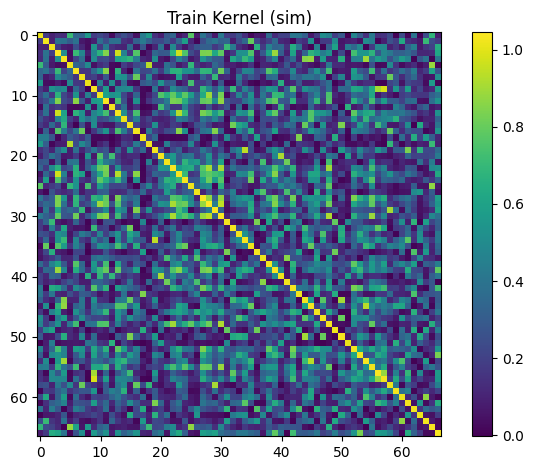

[1 0 1 0 1 0 0 1 1 1 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0
 1 1 0 1 0 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0]


In [16]:
K_train = qsvc.quantum_kernel.evaluate(x_vec=X_train)
plot_matrix(K_train,title='Train Kernel (sim)')
print(y_train)

## Test

In [17]:
score_train = qsvc.score(X_train, y_train)
print(f"Test score: {score_train}")

score_test = qsvc.score(X_test, y_test)
print(f"Test score: {score_test}")

Test score: 0.746268656716418
Test score: 0.48484848484848486


**Note:**

This is a bad accuracy score for such a primitive dataset. It indicates that the chosen feature map is suboptimal for the data set at hand. I am sure you can do better :). 


**Challenge:**

Try to find a feature map (parameterized QC) that produces better train/test accuracy.

You can design your own, or experiment with the prebuilt set of circuits from the [Qiskit Circuit Library](https://docs.quantum.ibm.com/api/qiskit/circuit_library).

Also experiment with different ways to preprocess your data.